In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns
import random
import math 
import psycopg2
import sys
sys.path.append('/home/ec2-user/FrequencyBounds/Source')
from SafeBoundUtils import *
from DBConnectionUtils import *
from SQLParser import * 
from PiecewiseConstantFunctionUtils import *

movieKeyword = pd.read_csv("../Data/JOB/movie_keyword.csv", quotechar = "\"", escapechar="\\", names=["id", "MovieId", "KeywordId"], low_memory=False)
movieInfo = pd.read_csv("../Data/JOB/movie_info.csv", quotechar = "\"", escapechar="\\",
                           names=["id", "movie_id", "info_type_id", "info", "note"], low_memory=False)

title = pd.read_csv("../Data/JOB/title.csv", quotechar = "\"", escapechar="\\",
                       names=["id", "title", "imdb_index", "kind_id", "production_year", "imdb_id",
                              "phonetic_code", "episode_of_id", "season_nr", "episode_nr", "series_years", "md5sum"], low_memory=False)

company_name = pd.read_csv("../Data/JOB/company_name.csv", quotechar = "\"", escapechar="\\",
                           names=["id", "name", "country_code", "imdb_id", "name_pcode_nf", "name_pcode_sf", "md5sum"], low_memory=False)
movie_companies = pd.read_csv("../Data/JOB/movie_companies.csv", quotechar = "\"", escapechar="\\",
                           names=["id", "movie_id", "company_id", "company_type_id", "note"], low_memory=False)
movie_companies_full = movie_companies.merge(company_name, left_on="company_id", right_on="id").merge(title, left_on="movie_id", right_on="id")

In [2]:
table = movie_companies_full
tableName = "movie_companies_full"
joinCol = "company_id"
filterCol = "production_year"
numValuesToKeep = min(100, len(table[filterCol].value_counts(ascending=False)))
tableDFs = [table]
tableNames= [tableName]
tableJoinCols = [[joinCol]]
relativeErrorPerSegment = .01
originalFilterCols = [[filterCol]]
table = table[~table[filterCol].isna()]
table = table[~table[joinCol].isna()]
valuesOfScores = table[filterCol].value_counts(ascending=False).head(numValuesToKeep).index
numGroupChoices = [4, 8, 16, 32, 64]
selfJoinErrorsPerGroupsSingle = []
selfJoinErrorsPerGroupsComplete = []
selfJoinErrorsPerGroupsNaive = []
selfJoinErrorsPerGroupsSinglePDF = []
selfJoinErrorsPerGroupsCompletePDF = []
selfJoinErrorsPerGroupsNaivePDF = []
trueSelfJoinSize = []

for value in valuesOfScores:
    trueSelfJoinSize.append(sum([x**2 for x  in table[table[filterCol]==value][joinCol].value_counts()]))

for numGroups in numGroupChoices:    
    safeBoundStatsSingle = SafeBound(tableDFs, tableNames, tableJoinCols, relativeErrorPerSegment, originalFilterCols = originalFilterCols, 
                                numBuckets = 0, numEqualityOutliers=numValuesToKeep, FKtoKDict = dict(),
                                numOutliers = numGroups, trackNulls=False, trackBiGrams=False, numCores=12, 
                                groupingMethod="SingleClustering", verbose=False)    
    safeBoundStatsComplete = SafeBound(tableDFs, tableNames, tableJoinCols, relativeErrorPerSegment, originalFilterCols = originalFilterCols, 
                                numBuckets = 0, numEqualityOutliers=numValuesToKeep, FKtoKDict = dict(),
                                numOutliers = numGroups, trackNulls=False, trackBiGrams=False, numCores=12,
                                groupingMethod="CompleteClustering",  verbose=False)    
    safeBoundStatsNaive = SafeBound(tableDFs, tableNames, tableJoinCols, relativeErrorPerSegment, originalFilterCols = originalFilterCols, 
                                numBuckets = 0, numEqualityOutliers=numValuesToKeep, FKtoKDict = dict(),
                                numOutliers = numGroups, trackNulls=False, trackBiGrams=False, numCores=12,
                                groupingMethod="Naive",  verbose=False)
    
    
    safeBoundStatsSinglePDF = SafeBound(tableDFs, tableNames, tableJoinCols, relativeErrorPerSegment, originalFilterCols = originalFilterCols, 
                                numBuckets = 0, numEqualityOutliers=numValuesToKeep, FKtoKDict = dict(),
                                numOutliers = numGroups, trackNulls=False, trackBiGrams=False, numCores=12, 
                                groupingMethod="SingleClustering", modelCDF=False, verbose=False)    
    safeBoundStatsCompletePDF = SafeBound(tableDFs, tableNames, tableJoinCols, relativeErrorPerSegment, originalFilterCols = originalFilterCols, 
                                numBuckets = 0, numEqualityOutliers=numValuesToKeep, FKtoKDict = dict(),
                                numOutliers = numGroups, trackNulls=False, trackBiGrams=False, numCores=12,
                                groupingMethod="CompleteClustering", modelCDF=False, verbose=False)    
    safeBoundStatsNaivePDF = SafeBound(tableDFs, tableNames, tableJoinCols, relativeErrorPerSegment, originalFilterCols = originalFilterCols, 
                                numBuckets = 0, numEqualityOutliers=numValuesToKeep, FKtoKDict = dict(),
                                numOutliers = numGroups, trackNulls=False, trackBiGrams=False, numCores=12,
                                groupingMethod="Naive", modelCDF=False, verbose=False)
    
    selfJoinErrorsSingle = []
    selfJoinErrorsComplete = []
    selfJoinErrorsNaive = []
    selfJoinErrorsSinglePDF = []
    selfJoinErrorsCompletePDF = []
    selfJoinErrorsNaivePDF = []
    for i, value in enumerate(valuesOfScores):
        queryGraph = JoinQueryGraph()
        queryGraph.addAlias(tableName, "p1")
        queryGraph.addAlias(tableName, "p2")
        queryGraph.addJoin("p1", joinCol, "p2", joinCol)
        queryGraph.addPredicate("p1", filterCol, "=", value)
        queryGraph.addPredicate("p2", filterCol, "=", value)
        queryGraph.buildJoinGraph()
        
        estimatedJoinSizeSingle = safeBoundStatsSingle.functionalFrequencyBound(queryGraph)
        estimatedJoinSizeSinglePDF = safeBoundStatsSinglePDF.functionalFrequencyBound(queryGraph)
        estimatedJoinSizeComplete = safeBoundStatsComplete.functionalFrequencyBound(queryGraph)
        estimatedJoinSizeCompletePDF = safeBoundStatsCompletePDF.functionalFrequencyBound(queryGraph)
        estimatedJoinSizeNaive = safeBoundStatsNaive.functionalFrequencyBound(queryGraph)
        estimatedJoinSizeNaivePDF = safeBoundStatsNaivePDF.functionalFrequencyBound(queryGraph)
        
        selfJoinErrorsSingle.append(estimatedJoinSizeSingle / trueSelfJoinSize[i])
        selfJoinErrorsComplete.append(estimatedJoinSizeComplete / trueSelfJoinSize[i])
        selfJoinErrorsNaive.append(estimatedJoinSizeNaive / trueSelfJoinSize[i])
        selfJoinErrorsSinglePDF.append(estimatedJoinSizeSinglePDF / trueSelfJoinSize[i])
        selfJoinErrorsCompletePDF.append(estimatedJoinSizeCompletePDF / trueSelfJoinSize[i])
        selfJoinErrorsNaivePDF.append(estimatedJoinSizeNaivePDF / trueSelfJoinSize[i])
    selfJoinErrorsPerGroupsSingle.append(selfJoinErrorsSingle)
    selfJoinErrorsPerGroupsComplete.append(selfJoinErrorsComplete)
    selfJoinErrorsPerGroupsNaive.append(selfJoinErrorsNaive)
    selfJoinErrorsPerGroupsSinglePDF.append(selfJoinErrorsSinglePDF)
    selfJoinErrorsPerGroupsCompletePDF.append(selfJoinErrorsCompletePDF)
    selfJoinErrorsPerGroupsNaivePDF.append(selfJoinErrorsNaivePDF)

/home/ec2-user/anaconda3/lib/python3.9/concurrent/futures/thread.py:58: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  result = self.fn(*self.args, **self.kwargs)
/home/ec2-user/anaconda3/lib/python3.9/multiprocessing/pool.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return list(itertools.starmap(args[0], args[1]))
/home/ec2-user/anaconda3/lib/python3.9/concurrent/futures/thread.py:58: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  result = self.fn(*self.args, **self.kwargs)
/home/ec2-user/anaconda3/lib/python3.9/multiprocessing/pool.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

In [11]:
averageSelfJoinErrorsPerGroupsSingle = [sum(errors)/len(errors) for errors in selfJoinErrorsPerGroupsSingle]
averageSelfJoinErrorsPerGroupsComplete= [sum(errors)/len(errors) for errors in selfJoinErrorsPerGroupsComplete]
averageSelfJoinErrorsPerGroupsNaive= [sum(errors)/len(errors) for errors in selfJoinErrorsPerGroupsNaive]
averageSelfJoinErrorsPerGroupsSinglePDF = [sum(errors)/len(errors) for errors in selfJoinErrorsPerGroupsSinglePDF]
averageSelfJoinErrorsPerGroupsCompletePDF = [sum(errors)/len(errors) for errors in selfJoinErrorsPerGroupsCompletePDF]
averageSelfJoinErrorsPerGroupsNaivePDF = [sum(errors)/len(errors) for errors in selfJoinErrorsPerGroupsNaivePDF]
compressionRatio = [numValuesToKeep/numGroups for numGroups in numGroupChoices]

In [12]:
[min(x) for x in selfJoinErrorsPerGroupsComplete]

[1.3232823806458849,
 1.2508297730102467,
 1.242421159803142,
 1.234207572261488,
 1.179767876771216]

In [13]:
averageSelfJoinErrorsPerGroupsSingle

[10.557345480478023,
 9.889922278374174,
 7.8523566881743285,
 7.617467363777625,
 7.4726319692173755]

In [14]:
averageSelfJoinErrorsPerGroupsComplete

[8.195440809773265,
 7.94745824646243,
 7.674632445287292,
 7.574358808467488,
 7.4319860457626445]

In [15]:
averageSelfJoinErrorsPerGroupsNaive

[13.15082034816569,
 9.737946662213936,
 8.272280862683742,
 7.839179437762989,
 7.467134190584748]

In [16]:
averageSelfJoinErrorsPerGroupsSinglePDF

[36.80030423648131,
 11.934318309610036,
 7.763893473928277,
 7.289542994392607,
 6.973537575929881]

In [17]:
averageSelfJoinErrorsPerGroupsCompletePDF

[9.171257055397946,
 8.219904805073732,
 7.453672970198743,
 7.1495874095032885,
 6.944526756875515]

In [18]:
averageSelfJoinErrorsPerGroupsNaivePDF

[20.180316844644395,
 13.308709101692418,
 9.627426281446414,
 7.944660870394867,
 7.28520721449369]

[None,
 None,
 Text(0, 0.5, 'Average Self-Join Error'),
 Text(0.5, 0, 'Compression Ratio'),
 (4, 100)]

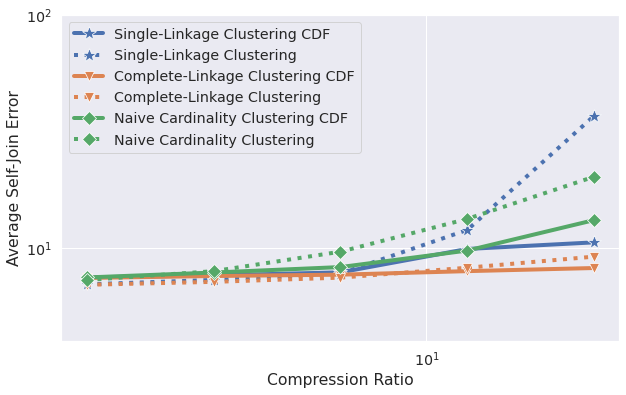

In [19]:
sns.set(rc={'figure.figsize':(10,6)})
sns.set_style("whitegrid")
sns.set_color_codes("pastel")
sns.set(font_scale = 1.3)
lineplot = sns.lineplot(x = compressionRatio, y = averageSelfJoinErrorsPerGroupsSingle, color = "C0", linewidth=4,linestyle="-", marker="*", markersize=15, label="Single-Linkage Clustering CDF")
lineplot = sns.lineplot(x = compressionRatio, y = averageSelfJoinErrorsPerGroupsSinglePDF, color = "C0", linewidth=4,linestyle=":", marker="*", markersize=15, label="Single-Linkage Clustering")
lineplot = sns.lineplot(x = compressionRatio, y = averageSelfJoinErrorsPerGroupsComplete, color = "C1", linewidth=4,linestyle="-", marker="v", markersize=10, label="Complete-Linkage Clustering CDF")
lineplot = sns.lineplot(x = compressionRatio, y = averageSelfJoinErrorsPerGroupsCompletePDF, color = "C1", linewidth=4,linestyle=":", marker="v", markersize=10, label="Complete-Linkage Clustering")
lineplot = sns.lineplot(x = compressionRatio, y = averageSelfJoinErrorsPerGroupsNaive, color = "C2", linewidth=4,linestyle="-", marker="D", markersize=10, label="Naive Cardinality Clustering CDF")
lineplot = sns.lineplot(x = compressionRatio, y = averageSelfJoinErrorsPerGroupsNaivePDF, color = "C2", linewidth=4,linestyle=":", marker="D", markersize=10, label="Naive Cardinality Clustering")
lineplot.set(yscale='log', xscale='log', ylabel='Average Self-Join Error', xlabel="Compression Ratio", ylim=[4,100])

In [20]:
table = title
tableName = "title"
joinCol = "episode_of_id"
filterCol = "production_year"
relativeErrorThreshold = [.2, .1, .05, .0125, .005, .001, .0005]
numSegmentsExponential = [2, 5, 10, 20, 40, 80, 100]
numSegmentsLinear = [2, 75, 100, 200, 400, 800, 1600]
perfectApproxSize = table[joinCol].value_counts().nunique()
degreeSequence = np.array(table[joinCol].value_counts(ascending=False).to_list(), dtype=np.int64)
selfJoinSize = sum([x**2 for x in degreeSequence])
exponentialErrors = []
linearErrors = []
relativeErrorErrors = []
exponentialSegments = []
linearSegments = []
relativeErrorSegments = []
exponentialErrorsPDF = []
linearErrorsPDF = []
relativeErrorErrorsPDF = []
exponentialSegmentsPDF = []
linearSegmentsPDF = []
relativeErrorSegmentsPDF = []
for i in range(len(relativeErrorThreshold)):
    functionExponential = PiecewiseConstantFunction(degreeSequence, numSegmentsExponential[i], "Exponential")
    print(functionExponential.constants[0])
    selfJoinExponential = functionExponential.getSelfJoinSize()
    exponentialErrors.append(selfJoinExponential/selfJoinSize)
    exponentialSegments.append(perfectApproxSize/len(functionExponential.constants))
    functionLinear = PiecewiseConstantFunction(degreeSequence, numSegmentsLinear[i], "Linear")
    selfJoinLinear = functionLinear.getSelfJoinSize()
    linearSegments.append(perfectApproxSize/len(functionLinear.constants))
    linearErrors.append(selfJoinLinear/selfJoinSize)
    functionRelativeError = PiecewiseConstantFunction(degreeSequence, relativeErrorThreshold[i], "RelativeError")
    selfJoinRelativeError = functionRelativeError.getSelfJoinSize()
    relativeErrorErrors.append(selfJoinRelativeError/selfJoinSize)    
    relativeErrorSegments.append(perfectApproxSize/len(functionRelativeError.constants))
    
    functionExponential = PiecewiseConstantFunction(degreeSequence, numSegmentsExponential[i], "Exponential", False)
    print(functionExponential.constants[0])
    selfJoinExponential = functionExponential.getSelfJoinSize()
    exponentialErrorsPDF.append(selfJoinExponential/selfJoinSize)
    exponentialSegmentsPDF.append(perfectApproxSize/len(functionExponential.constants))
    functionLinear = PiecewiseConstantFunction(degreeSequence, numSegmentsLinear[i], "Linear", False)
    selfJoinLinear = functionLinear.getSelfJoinSize()
    linearSegmentsPDF.append(perfectApproxSize/len(functionLinear.constants))
    linearErrorsPDF.append(selfJoinLinear/selfJoinSize)
    functionRelativeError = PiecewiseConstantFunction(degreeSequence, relativeErrorThreshold[i], "RelativeError", False)
    selfJoinRelativeError = functionRelativeError.getSelfJoinSize()
    relativeErrorErrorsPDF.append(selfJoinRelativeError/selfJoinSize)    
    relativeErrorSegmentsPDF.append(perfectApproxSize/len(functionRelativeError.constants))

8111.0
8111.0
8111.0
8111.0
8111.0
8111.0
8111.0
8111.0
8111.0
8111.0
8111.0
8111.0
8111.0
8111.0


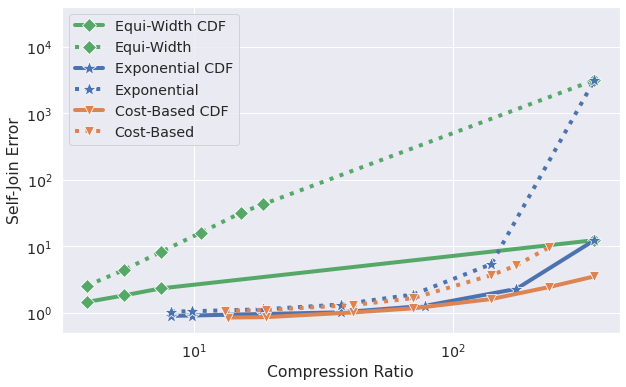

In [21]:
sns.set(rc={'figure.figsize':(10,6)})
sns.set_style("whitegrid")
sns.set_color_codes("pastel")
sns.set(font_scale = 1.3)
lineplot = sns.lineplot(x = linearSegments, y = linearErrors, color = "C2", linewidth=4,linestyle="-", marker="D", markersize=10, label="Equi-Width CDF")
lineplot = sns.lineplot(x = linearSegmentsPDF, y = linearErrorsPDF, color = "C2", linewidth=4,linestyle=":", marker="D", markersize=10, label="Equi-Width")
lineplot = sns.lineplot(x = exponentialSegments, y = exponentialErrors, color = "C0", linewidth=4,linestyle="-", marker="*", markersize=15, label="Exponential CDF")
lineplot = sns.lineplot(x = exponentialSegmentsPDF, y = exponentialErrorsPDF, color = "C0", linewidth=4,linestyle=":", marker="*", markersize=15, label="Exponential")
lineplot = sns.lineplot(x = relativeErrorSegments, y = relativeErrorErrors, color = "C1", linewidth=4,linestyle="-", marker="v", markersize=10, label="Cost-Based CDF")
lineplot = sns.lineplot(x = relativeErrorSegmentsPDF, y = relativeErrorErrorsPDF, color = "C1", linewidth=4,linestyle=":", marker="v", markersize=10, label="Cost-Based")
lineplot.set(yscale='log', xscale='log', ylabel='Self-Join Error', xlabel="Compression Ratio", ylim=[.5, 40000])
plt.show()

In [10]:
functionExponential.printDiagnostics()

Interval: [0, 1.0)    Constant: 8111.0  Cumulative Rows: 8111.0
Interval: [1.0, 2.0)    Constant: 7303.0  Cumulative Rows: 15414.0
Interval: [2.0, 3.0)    Constant: 6463.0  Cumulative Rows: 21877.0
Interval: [3.0, 4.0)    Constant: 5338.0  Cumulative Rows: 27215.0
Interval: [4.0, 5.0)    Constant: 5317.0  Cumulative Rows: 32532.0
Interval: [5.0, 6.0)    Constant: 5212.0  Cumulative Rows: 37744.0
Interval: [6.0, 7.0)    Constant: 4716.0  Cumulative Rows: 42460.0
Interval: [7.0, 8.0)    Constant: 4499.0  Cumulative Rows: 46959.0
Interval: [8.0, 9.0)    Constant: 3809.0  Cumulative Rows: 50768.0
Interval: [9.0, 10.0)    Constant: 3558.0  Cumulative Rows: 54326.0
Interval: [10.0, 11.0)    Constant: 3497.0  Cumulative Rows: 57823.0
Interval: [11.0, 13.0)    Constant: 3109.0  Cumulative Rows: 64041.0
Interval: [13.0, 14.0)    Constant: 2759.0  Cumulative Rows: 66800.0
Interval: [14.0, 16.0)    Constant: 2669.0  Cumulative Rows: 72138.0
Interval: [16.0, 18.0)    Constant: 2563.0  Cumulative R

In [11]:
for edge in calculateBins(43239, 10):
    print(edge)

1
2
2
10


In [12]:
functionExponential.compressFunc(20)

In [13]:
functionExponential.printDiagnostics()

Interval: [0, 3.0)    Constant: 8111.0  Cumulative Rows: 24333.0
Interval: [3.0, 5.0)    Constant: 6463.0  Cumulative Rows: 37259.0
Interval: [5.0, 9.0)    Constant: 5317.0  Cumulative Rows: 58527.0
Interval: [9.0, 16.0)    Constant: 3809.0  Cumulative Rows: 85190.0
Interval: [16.0, 29.0)    Constant: 2669.0  Cumulative Rows: 119887.0
Interval: [29.0, 51.0)    Constant: 1706.0  Cumulative Rows: 157419.0
Interval: [51.0, 89.0)    Constant: 1068.0  Cumulative Rows: 198003.0
Interval: [89.0, 157.0)    Constant: 694.0  Cumulative Rows: 245195.0
Interval: [157.0, 275.0)    Constant: 496.0  Cumulative Rows: 303723.0
Interval: [275.0, 482.0)    Constant: 314.0  Cumulative Rows: 368721.0
Interval: [482.0, 847.0)    Constant: 232.0  Cumulative Rows: 453401.0
Interval: [847.0, 1485.0)    Constant: 170.0  Cumulative Rows: 561861.0
Interval: [1485.0, 2605.0)    Constant: 123.0  Cumulative Rows: 699621.0
Interval: [2605.0, 4569.0)    Constant: 83.0  Cumulative Rows: 862633.0
Interval: [4569.0, 8014

7303.0